In [21]:
import cv2
import numpy as np
import os
import math
import pandas as pd
import skimage.measure as measure
from matplotlib import pyplot as plt


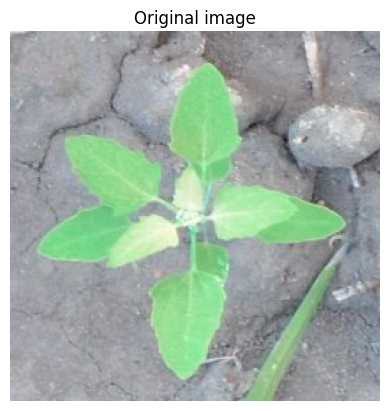

In [22]:
#Preprocessing for a single image

# Load the image
image = cv2.imread('1.jpg')
plt.imshow(image)
plt.title('Original image')
plt.axis('off')
plt.show()

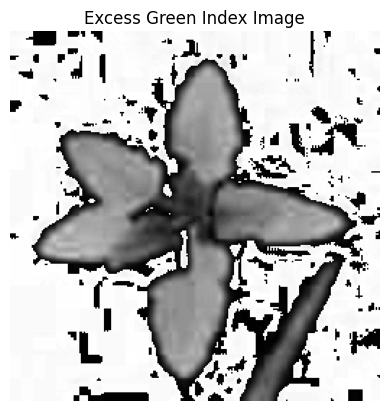

In [23]:
#Excess green index

# Split the image into its BGR components
blue, green, red = cv2.split(image)
# Calculate excess green index (ExG)
exg = 2 * green - red - blue

# Convert ExG image to 3-channel (compatible for conversion)
exg_3channel = cv2.merge([exg, exg, exg])
plt.imshow(exg, cmap='gray')
plt.title('Excess Green Index Image')
plt.axis('off')
plt.show()

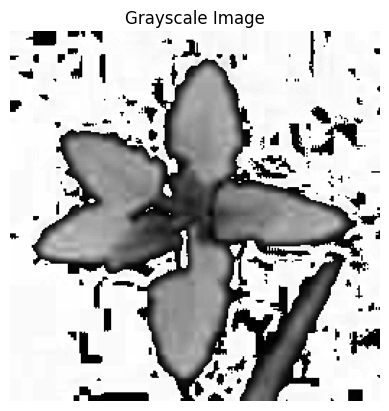

In [24]:
# Convert the ExG image to grayscale
grayscale_image = cv2.cvtColor(exg_3channel, cv2.COLOR_BGR2GRAY)
plt.imshow(grayscale_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

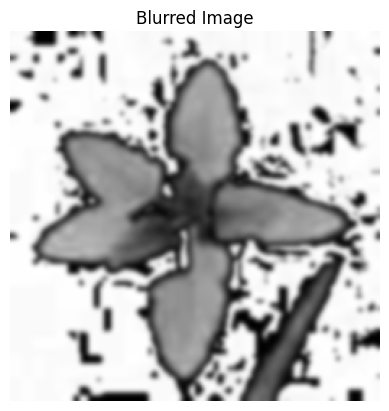

In [25]:
# Apply additional preprocessing (e.g., blurring) to the grayscale image

blurred_image = cv2.GaussianBlur(grayscale_image, (9, 9), 0)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')
plt.show()

In [26]:
# Apply k-means clustering to segment the preprocessed image
pixels = np.float32(blurred_image.reshape(-1, 1))
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(pixels, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
print("labels:",labels)
print("centers:",centers)

labels: [[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]
centers: [[239.79059 ]
 [107.741005]]


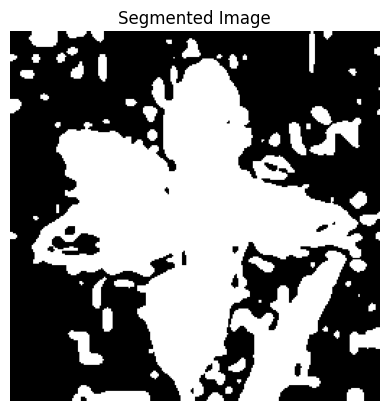

In [27]:
# Extract the cluster corresponding to the plant
segmented_image = labels.reshape(grayscale_image.shape)
plt.imshow(segmented_image, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')
plt.show()

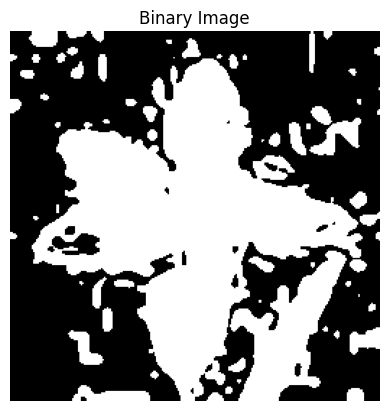

In [28]:
plant_cluster = 0 if centers[0] < centers[1] else 1
binary_image = np.uint8(segmented_image == plant_cluster) * 255
plt.imshow(binary_image, cmap='gray')
plt.title('Binary Image')
plt.axis('off')
plt.show()

In [29]:
# Find contours in the binary image
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print("contours:",contours)

contours: (array([[[140, 250]],

       [[137, 253]],

       [[137, 254]],

       [[136, 255]],

       [[147, 255]],

       [[147, 254]],

       [[146, 253]],

       [[146, 252]],

       [[145, 252]],

       [[143, 250]]], dtype=int32), array([[[236, 247]],

       [[235, 248]],

       [[234, 248]],

       [[234, 249]],

       [[233, 250]],

       [[233, 255]],

       [[244, 255]],

       [[244, 250]],

       [[243, 249]],

       [[243, 248]],

       [[242, 248]],

       [[241, 247]]], dtype=int32), array([[[150, 246]],

       [[149, 247]],

       [[149, 250]],

       [[152, 250]],

       [[153, 249]],

       [[153, 247]],

       [[152, 246]]], dtype=int32), array([[[ 49, 245]],

       [[ 47, 247]],

       [[ 47, 250]],

       [[ 46, 251]],

       [[ 45, 251]],

       [[ 44, 252]],

       [[ 44, 253]],

       [[ 43, 254]],

       [[ 43, 255]],

       [[ 48, 255]],

       [[ 48, 253]],

       [[ 49, 252]],

       [[ 51, 252]],

       [[ 53, 254]],

 

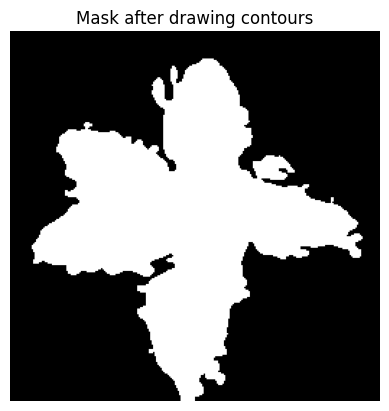

In [30]:
# Create a mask based on the largest contour
mask = np.zeros_like(binary_image)
if contours:
  largest_contour = max(contours, key=cv2.contourArea)
cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), thickness=cv2.FILLED)
plt.imshow(mask, cmap='gray')
plt.title('Mask after drawing contours')
plt.axis('off')
plt.show()

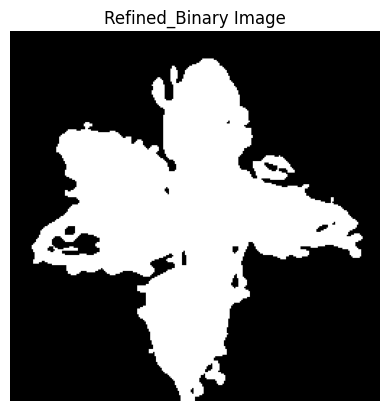

In [31]:
# Apply the mask to the binary image
refined_binary_image = cv2.bitwise_and(binary_image, mask)
plt.imshow(refined_binary_image, cmap='gray')
plt.title('Refined_Binary Image')
plt.axis('off')
plt.show()

In [32]:
#Feature extraction for a single image

# Label connected components in the refined binary image
labeled_mask = measure.label(refined_binary_image)
# Measure properties of labeled regions (particles)
properties = measure.regionprops(labeled_mask)
# Find the index of the largest connected component
largest_component_index = max(range(len(properties)), key=lambda i: properties[i].area)
# Extract properties for the largest connected component
largest_component_properties = properties[largest_component_index]

In [33]:
# Calculate ratios and additional properties
circularity = (4 * math.pi * largest_component_properties.area) / largest_component_properties.perimeter ** 2
aspect_ratio = largest_component_properties.major_axis_length / largest_component_properties.minor_axis_length
solidity = largest_component_properties.area / largest_component_properties.convex_area
roundness = 4 * largest_component_properties.area / (math.pi * largest_component_properties.major_axis_length ** 2)

hollowness = (largest_component_properties.convex_area - largest_component_properties.area) / largest_component_properties.convex_area
rar = 1 / aspect_ratio
rectangularity = largest_component_properties.area / largest_component_properties.bbox_area
feret_diameters = measure.regionprops_table(labeled_mask, properties=["feret_diameter_max"])
feret_major_axis = feret_diameters['feret_diameter_max'].max()
feret_minor_axis = feret_diameters['feret_diameter_max'].min()
feret_major_axis_ratio = feret_major_axis / largest_component_properties.major_axis_length
feret_minor_axis_ratio = feret_minor_axis / largest_component_properties.minor_axis_length
favg = (feret_major_axis + feret_minor_axis) / 2
convex_area_feret_ratio = largest_component_properties.convex_area / favg ** 2

compactness = largest_component_properties.area / favg
min_compactness = 0
max_compactness = 200
compactness_normalized = (compactness - min_compactness) / (max_compactness - min_compactness)

area_length_ratio = largest_component_properties.area / largest_component_properties.major_axis_length ** 2
log_height_width_ratio = np.log( largest_component_properties.major_axis_length / largest_component_properties.minor_axis_length)
elongation = (largest_component_properties.major_axis_length - largest_component_properties.minor_axis_length) / (
largest_component_properties.major_axis_length + largest_component_properties.minor_axis_length)

perimeter_broadness_ratio = largest_component_properties.perimeter / 2 * (
largest_component_properties.major_axis_length + largest_component_properties.minor_axis_length)

min_pb_ratio = 10000
max_pb_ratio = 700000
perimeter_broadness_ratio_normalized = (perimeter_broadness_ratio - min_pb_ratio) / ( max_pb_ratio - min_pb_ratio)
length_perimeter_ratio = largest_component_properties.major_axis_length / largest_component_properties.perimeter

modified_circularity = 4 * largest_component_properties.area / ( largest_component_properties.perimeter * favg)
grum_circularity = (16 * largest_component_properties.area ** 2) / ( 4 * math.pi * largest_component_properties.perimeter * (favg ** 3))
area_compactness = (4 * largest_component_properties.area) / (math.pi * favg ** 2)
eq = 2.0 * math.sqrt(math.pi * largest_component_properties.area)
equivalent_perimeter_ratio = largest_component_properties.perimeter / eq

In [34]:
# Store the results in a dictionary
features = {
  'Area': largest_component_properties.area,
  'Circularity': circularity,
  'Aspect_Ratio': aspect_ratio,
  'Solidity': solidity,
  'Roundness': roundness,
  'Hollowness': hollowness,
  'Reverse_Aspect_Ratio': rar,
  'Rectangularity': rectangularity,
  'Feret_Major_Axis_Ratio': feret_major_axis_ratio,
  'Feret_Minor_Axis_Ratio': feret_minor_axis_ratio,
  'Convex_Area_Feret_Ratio': convex_area_feret_ratio,
  'Compactness': compactness_normalized,
  'Area_Length_Ratio': area_length_ratio,
  'Log_Height_Width_Ratio': log_height_width_ratio,
  'Elongation': elongation,
  'Perimeter_Broadness_Ratio': perimeter_broadness_ratio_normalized,
  'Length_Perimeter_Ratio': length_perimeter_ratio,
  'Modified_Circularity': modified_circularity,
  'Grum_Circularity': grum_circularity,
  # Store the results in a dictionary (continued)
  'Area_Compactness': area_compactness,
  'Equivalent_Perimeter_Ratio': equivalent_perimeter_ratio
}

In [35]:
#Features obtained for a single image
for key,value in features.items():
  print(key,value)

Area 21988
Circularity 0.09515700877901921
Aspect_Ratio 1.081060572847329
Solidity 0.6525790942007479
Roundness 0.7193028651173942
Hollowness 0.3474209057992521
Reverse_Aspect_Ratio 0.9250175476903858
Rectangularity 0.40513699261142744
Feret_Major_Axis_Ratio 1.2069571210780894
Feret_Minor_Axis_Ratio 1.3047937567148424
Convex_Area_Feret_Ratio 0.5942714028713535
Compactness 0.46171274496078085
Area_Length_Ratio 0.5649391491897239
Log_Height_Width_Ratio 0.07794257117355628
Elongation 0.03895156820756111
Perimeter_Broadness_Ratio 0.4544556264629465
Length_Perimeter_Ratio 0.11577495558924282
Modified_Circularity 0.21676264638015483
Grum_Circularity 0.026757932911919954
Area_Compactness 0.49377387402795087
Equivalent_Perimeter_Ratio 3.241750669005786


In [36]:
#PREPROCESSING AND FEATURE EXTRACTION FOR ALL THE IMAGES

import cv2
import numpy as np
import os
import math
import pandas as pd
import skimage.measure as measure
from matplotlib import pyplot as plt

#preprocessing

def calculate_excess_green_index(image):
 # Split the image into its BGR components
  blue, green, red = cv2.split(image)
  # Calculate excess green index (ExG)
  exg = 2 * green - red - blue
  return exg

def preprocess_image(image_path, image_id):
 # Load the image
  image = cv2.imread(image_path)

  # Calculate Excess Green Index
  exg = calculate_excess_green_index(image)

  # Convert ExG image to 3-channel (compatible for conversion)
  exg_3channel = cv2.merge([exg, exg, exg])

  # Convert the ExG image to grayscale
  grayscale_image = cv2.cvtColor(exg_3channel, cv2.COLOR_BGR2GRAY)

  # Apply additional preprocessing (e.g., blurring) to the grayscale image
  blurred_image = cv2.GaussianBlur(grayscale_image, (9, 9), 0)

  # Apply k-means clustering to segment the preprocessed image
  pixels = np.float32(blurred_image.reshape(-1, 1))
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
  _, labels, centers = cv2.kmeans(pixels, 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

  # Extract the cluster corresponding to the plant
  segmented_image = labels.reshape(grayscale_image.shape)

  plant_cluster = 0 if centers[0] < centers[1] else 1
  binary_image = np.uint8(segmented_image == plant_cluster) * 255
  # Find contours in the binary image
  contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  # Create a mask based on the largest contour
  mask = np.zeros_like(binary_image)
  if contours:
    largest_contour = max(contours, key=cv2.contourArea)
  cv2.drawContours(mask, [largest_contour], -1, (255, 255, 255), thickness=cv2.FILLED)

  # Apply the mask to the binary image
  refined_binary_image = cv2.bitwise_and(binary_image, mask)

  # Label connected components in the refined binary image
  labeled_mask = measure.label(refined_binary_image)

  # Measure properties of labeled regions (particles)
  properties = measure.regionprops(labeled_mask)

  # Find the index of the largest connected component
  largest_component_index = max(range(len(properties)), key=lambda i: properties[i].area)
  # Extract properties for the largest connected component
  largest_component_properties = properties[largest_component_index]

  # Calculate ratios and additional properties
  circularity = (4 * math.pi * largest_component_properties.area) / largest_component_properties.perimeter ** 2
  aspect_ratio = largest_component_properties.major_axis_length / largest_component_properties.minor_axis_length
  solidity = largest_component_properties.area / largest_component_properties.convex_area
  roundness = 4 * largest_component_properties.area / (math.pi * largest_component_properties.major_axis_length ** 2)
  hollowness = (largest_component_properties.convex_area - largest_component_properties.area) / largest_component_properties.convex_area
  rar = 1 / aspect_ratio
  rectangularity = largest_component_properties.area / largest_component_properties.bbox_area
  feret_diameters = measure.regionprops_table(labeled_mask, properties=["feret_diameter_max"])
  feret_major_axis = feret_diameters['feret_diameter_max'].max()
  feret_minor_axis = feret_diameters['feret_diameter_max'].min()
  feret_major_axis_ratio = feret_major_axis / largest_component_properties.major_axis_length
  feret_minor_axis_ratio = feret_minor_axis / largest_component_properties.minor_axis_length
  favg = (feret_major_axis + feret_minor_axis) / 2
  convex_area_feret_ratio = largest_component_properties.convex_area / favg ** 2
  compactness = largest_component_properties.area / favg
  min_compactness = 0
  max_compactness = 200
  compactness_normalized = (compactness - min_compactness) / (max_compactness - min_compactness)
  area_length_ratio = largest_component_properties.area / largest_component_properties.major_axis_length ** 2
  log_height_width_ratio = np.log( largest_component_properties.major_axis_length / largest_component_properties.minor_axis_length)
  elongation = (largest_component_properties.major_axis_length - largest_component_properties.minor_axis_length) / (
  largest_component_properties.major_axis_length + largest_component_properties.minor_axis_length)
  perimeter_broadness_ratio = largest_component_properties.perimeter / 2 * (
  largest_component_properties.major_axis_length + largest_component_properties.minor_axis_length)
  min_pb_ratio = 10000
  max_pb_ratio = 700000
  perimeter_broadness_ratio_normalized = (perimeter_broadness_ratio - min_pb_ratio) / ( max_pb_ratio - min_pb_ratio)
  length_perimeter_ratio = largest_component_properties.major_axis_length / largest_component_properties.perimeter
  modified_circularity = 4 * largest_component_properties.area / ( largest_component_properties.perimeter * favg)
  grum_circularity = (16 * largest_component_properties.area ** 2) / ( 4 * math.pi * largest_component_properties.perimeter * (favg ** 3))
  area_compactness = (4 * largest_component_properties.area) / (math.pi * favg ** 2)
  eq = 2.0 * math.sqrt(math.pi * largest_component_properties.area)
  equivalent_perimeter_ratio = largest_component_properties.perimeter / eq

  # Store the results in a dictionary
  features = {
  'Image_ID': image_id,
  'Area': largest_component_properties.area,
  'Circularity': circularity,
  'Aspect_Ratio': aspect_ratio,
  'Solidity': solidity,
  'Roundness': roundness,
  'Hollowness': hollowness,
  'Reverse_Aspect_Ratio': rar,
  'Rectangularity': rectangularity,
  'Feret_Major_Axis_Ratio': feret_major_axis_ratio,
  'Feret_Minor_Axis_Ratio': feret_minor_axis_ratio,
  'Convex_Area_Feret_Ratio': convex_area_feret_ratio,
  'Compactness': compactness_normalized,
  'Area_Length_Ratio': area_length_ratio,
  'Log_Height_Width_Ratio': log_height_width_ratio,
  'Elongation': elongation,
  'Perimeter_Broadness_Ratio': perimeter_broadness_ratio_normalized,
  'Length_Perimeter_Ratio': length_perimeter_ratio,
  'Modified_Circularity': modified_circularity,
  'Grum_Circularity': grum_circularity,
  # Store the results in a dictionary (continued)
  'Area_Compactness': area_compactness,
  'Equivalent_Perimeter_Ratio': equivalent_perimeter_ratio
  }
  return features

# Iterate over each image in the directory
image_dir = '/content/sample_data/data'
results = []
image_id = 1 # Initial image ID

# Traverse through all directories and subdirectories within 'data'
for root, dirs, files in os.walk(image_dir):
    for filename in files:
        if filename.endswith('.jpg') or filename.endswith('.png'):
            image_path = os.path.join(root, filename)
            features = preprocess_image(image_path, image_id)
            results.append(features)
            image_id += 1 # Increment image ID for the next image

# Create a DataFrame from the results and save it to a CSV file
df = pd.DataFrame(results)
df.to_csv('output.csv', index=False)
